# COMP24112 - Exercise 3: _Face Recognition_

## 1. Task description

You will work on the face recognition and face completion tasks. The provided dataset includes face images of 40 subjects. There are a total of 400 images, with 10 images per subject. Each image contains 32×32=1024 pixels, with 256 grey levels per pixel.

## 2. Preparation

### Setting up

The functions that you need are defined in the source file we have provided you with. To use them you must import it first:

In [540]:
from lab3lib import load_data, show_single_face, show_faces, partition_data, split_left_right, join_left_right, show_split_faces
import numpy as np
import matplotlib.pyplot as plt
import math

Now you can load the data:

In [541]:
data, labels = load_data()

### Visualising the dataset

You can observe the faces stored in a data matrix by using the functions `show_single_face()` and `show_faces()`.

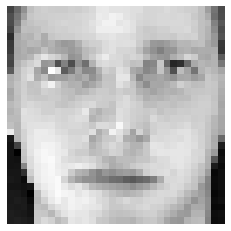

In [542]:
# Display a single example.
show_single_face(data[0, :])

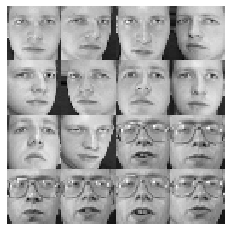

In [543]:
# Display the first 16 examples in a 4x4 grid.
show_faces(data[:16, :], num_per_row=4)

### Splitting into the train and test sets

Normalize your pixel values by 1/255 so that the feature values used in later experiments are between 0 and 1. In general, the normalization trick can make it easier for your to tune parameters in machine learning experiments. A data partition function is supplied to facilitate your experiments. It randomly splits the provided data into the training and test sets, where the training set contains $N$ samples per class and the test set contains
the remaining samples. It takes the labels and the specified number $N$ as the input. It returns the sample indices in the training and test set. For example, the following code divides a given set of 400 samples into a training set containing 3 samples per subject and a test set containing 7 samples per subject:

In [544]:
# normalization
data = data / 255

# partition
tr_ind, te_ind = partition_data(labels, num_per_class=3)
tr_data = data[tr_ind, :]
tr_label = labels[tr_ind]
te_data = data[te_ind, :]
te_label = labels[te_ind]

## 3. $L_2$-regularised least squares solution
### 3.1 Implementation
Now, you will need to implement the function `l2_rls_train` below. It should train a linear model by minimising the $L_2$-regularised sum of squares loss through zeroing the loss gradient. It should support both single-output and multi-output cases. This function should take a set of training samples and a user-specified regularisation parameter $\lambda$ as the input, and return the predicted weights. When $\lambda=0$, use pseudo inverse to implement the solution.

In [545]:
def l2_rls_train(data, labels, _lambda):
    """
    A summary of your function goes here.

    data: type and description of "data"
    labels: type and description of "labels"

    Returns: type and description of the returned variable(s).
    """
    
    # This is just to be consistent with the lecture notes.
    X, y = data, labels
    
    # Expand X with a column of ones.
    X_tilde = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
    
    # Compute the coefficient vector.
    if _lambda == 0:
        w = np.linalg.pinv(X_tilde)@y
    else:
        w = np.linalg.inv((X_tilde.T)@X_tilde + _lambda*np.eye(len((X_tilde.T)@X_tilde)))@(X_tilde.T)@y
        
    
    # Return model parameters.
    return w

Now, implement the function `l2_rls_predict` below. It should take the trained weights and your query data as the input, and return the corresponding prediction.

In [546]:
def l2_rls_predict(w, data):
    """
    A summary of your function goes here.

    data: type and description of "data"
    w: type and description of "w"

    Returns: type and description of the returned variable(s).
    """
    
   # Compute the prediction.
    matrix = np.concatenate((np.ones((data.shape[0], 1)), data), axis=1)
    predicted_y = matrix @ w
        
    return predicted_y

### 3.2 Experiments

Start to use your implemented functions to perform the following experiments.

#### Experiment 1: Binary Classification

Start with a binary classification task to classify face images for subjects “1” and “30”.

Train three classifiers:
1. Set $y=-1$ for samples from “1” and $y=+1$ for samples from “30” for training a linear model, and use the threshold $T= 0$ to obtain the class prediction.
2. Set $y=0$ for samples from “1” and $y=1$ for samples from “30” for training a linear model, and use the threshold $T= 0.5$ to obtain the class prediction.
2. Set $y=1$ for samples from “1” and $y=30$ for samples from “30” for training a linear model, and use the threshold $T= 15.5$ to obtain the class prediction.

Randomly select 3 images per subject for training, and use the remaining images for testing. Train your classifier 1 and test it with a fixed regularisation parameter $\lambda$=0. Repeat this process 50 times and record the training and test errors.

In [547]:
# Your code goes here
def experiment1(class1, class2, T):
    test_errors = list()
    train_errors = list()
    for i in range(50):
        training_indices, testing_indices = partition_data(labels, num_per_class=3)
        training_indices = training_indices[(labels[training_indices] == 1) | (labels[training_indices] == 30)]
        testing_indices = testing_indices[(labels[testing_indices] == 1) | (labels[testing_indices] == 30)]
        training_data = data[training_indices, :]
        testing_data = data[testing_indices, :]
        
        training_labels = np.array([class1, class1, class1, class2, class2, class2])
        testing_labels = np.array([class1, class1, class1, class1, class1, class1, class1, class2, class2, class2, class2, class2, class2, class2])

        w = l2_rls_train(training_data, training_labels, 0)
        predicted_y_training = l2_rls_predict(w, training_data)
        predicted_y_testing = l2_rls_predict(w, testing_data)
        
        for k in range(len(predicted_y_training)):
            if predicted_y_training[k]<T:
                predicted_y_training[k] = class1
            else:
                predicted_y_training[k] = class2
                
        train_errors.append((predicted_y_training!=training_labels).sum()/len(predicted_y_training))
        
        for j in range(len(predicted_y_testing)):
            if predicted_y_testing[j]<T:
                predicted_y_testing[j] = class1
            else:
                predicted_y_testing[j] = class2
        
        test_errors.append((predicted_y_testing!=testing_labels).sum()/len(predicted_y_testing))

    return np.mean(test_errors), np.std(test_errors), np.mean(train_errors), np.std(train_errors)


In [548]:
mean_test_1, std_test_1, mean_train_1, std_train_1 = experiment1(-1, 1, 0)
# print(mean_test_1)
# print(std_test_1)
# print(mean_train_1)
# print(std_train_1)

Repeat the same experiment for classifier 2.

In [549]:
# Your code goes here
mean_test_2, std_test_2, mean_train_2, std_train_2 = experiment1(0, 1, 0.5)
# print(mean_test_2)
# print(std_test_2)
# print(mean_train_2)
# print(std_train_2)

Repeat the same experiment for classifier 3.

In [550]:
# Your code goes here
mean_test_3, std_test_3, mean_train_3, std_train_3 = experiment1(1, 30, 15.5)
# print(mean_test_3)
# print(std_test_3)
# print(mean_train_3)
# print(std_train_3)

Print out the mean and the std values of the test errors of the three classifiers.

In [551]:
# Your code goes here
print("For classifier 1: ")
print("Mean: " + str(mean_test_1))
print("Standard deviation: " + str(std_test_1))
print()
print("For classifier 2: ")
print("Mean: " + str(mean_test_2))
print("Standard deviation: " + str(std_test_2))
print()
print("For classifier 3: ")
print("Mean: " + str(mean_test_3))
print("Standard deviation: " + str(std_test_3))

For classifier 1: 
Mean: 0.06857142857142856
Standard deviation: 0.10686630976722881

For classifier 2: 
Mean: 0.08571428571428572
Standard deviation: 0.12121830534626529

For classifier 3: 
Mean: 0.06142857142857142
Standard deviation: 0.07285714285714286


#### Experiment 2: Multi-class Classification

Now, proceed to the multi-class classification task to classify face images for all the 40 subjects.

Split your data to two sets: the training set contains 5 randomly selected images per subject and the test set contains the remaining images. The training set is used to train the model and select hyper-parameter $\lambda$, while the test set is only for final assessment of the trained classifier with the selected $\lambda$. 

Design an appropriate and complete machine learning experiment, which should include the training, hyper-parameter selection and evaluation stages. You can choose from the random subsampling, $k$-fold CV and LOO approaches for hyper-parameter selection. In the evaluation, you should construct a $40\times 40$ classification error matrix (confusion matrix) for test samples. 

Write your code below and make sure it compiles. 

In [552]:
# Your code goes here
from sklearn.model_selection import KFold
# Note that you may find it helpful to use one-hot encoding to deal with multi-class labels

training_indices, testing_indices = partition_data(labels, num_per_class=5)
training_data = data[training_indices, :]
testing_data = data[testing_indices, :]


row = np.zeros([1,40], dtype=int)
matrix = np.array(row)
matrix[0][0]=1
for i in range(1, len(labels)):   
    temp_row = np.zeros([1,40], dtype=int)
    temp_row[0][math.floor(i/10)] = 1 # we do this since we have 10 images per class (e.g image 37 will be class 3)
    matrix = np.concatenate((matrix, temp_row))
    
# matrix is a 400x40 matrix
# separate it into two matrices, training and testing

training_labels = matrix[training_indices] # 200x40 matrix
testing_labels = matrix[testing_indices] # 200x40 matrix


def hyper_param_selection(lambda_value):
    k_fold = KFold(n_splits=5, shuffle=True)
    # best lambda when the error is the smallest
    errors = list()
    for train_index, test_index in k_fold.split(training_indices):

        training_data_1 = data[train_index, :]
        testing_data_1 = data[test_index, :]
        training_labels_1 = matrix[train_index]
        testing_labels_1 = matrix[test_index]
        

        w = l2_rls_train(training_data_1, training_labels_1, lambda_value)
        predicted_y = l2_rls_predict(w, testing_data_1)
        
        # we need to construct another matrix for the predictions
        new_row = np.zeros([1,40], dtype=int)
        new_matrix = np.array(new_row)
        new_matrix[0][np.argmax(predicted_y[0])] = 1 # we are looking for the greatest result
        
        # rest of the matrix
        for i in range(1, len(predicted_y)):
            new_row = np.zeros([1,40], dtype=int)
            new_row[0][np.argmax(predicted_y[i])] = 1
            new_matrix = np.concatenate((new_matrix, new_row))
        

        errors.append((new_matrix!=testing_labels_1).sum()/len(new_matrix))
            
    return np.mean(errors), np.std(errors)






lambda_values = np.linspace(0, 15, num=31)
selected_lambda = float('inf')
lowest_error_mean = float('inf')
lowest_error_std = float('inf')
for value in range(len(lambda_values)):
    temp_mean, temp_std = hyper_param_selection(lambda_values[value])
    if temp_mean < lowest_error_mean:
        if temp_std < lowest_error_std:
            # save the best values
            selected_lambda = lambda_values[value]
            lowest_error_mean = temp_mean
            lowest_error_std = temp_std
            

# print out the best values
print("Lambda choice: " + str(selected_lambda) + "\n")
print("Respective mean: " + str(lowest_error_mean) + "\n")
print("Respective standard deviation: " + str(lowest_error_std))

Lambda choice: 4.5

Respective mean: 0.01

Respective standard deviation: 0.02


In [553]:
# now we need to use our best lambda for our testing
# we should also create a matrix for the predicted results

w_test = l2_rls_train(training_data, training_labels, selected_lambda)
predicted_y_testing = l2_rls_predict(w_test, testing_data)

matrix_row = np.zeros([1,40], dtype=int)
matrix_testing = np.array(matrix_row)
matrix_testing[0][np.argmax(predicted_y_testing[0])] = 1
for i in range(1, len(predicted_y_testing)):
    temp_row = np.zeros([1,40], dtype=int)
    temp_row[0][np.argmax(predicted_y_testing[i])] = 1
    matrix_testing = np.concatenate((matrix_testing, temp_row))
    

confusion_matrix_labels = np.array([], dtype=int)
for row in range(matrix_testing.shape[0]):
    for col in range(matrix_testing.shape[1]):
        if matrix_testing[row][col] == 1:
            confusion_matrix_labels = np.append(confusion_matrix_labels, np.array([col + 1]), axis = 0)
            break # since we only have one 1 in a row
            
      
    
print("Predictions:")
print(confusion_matrix_labels)

final_confusion_matrix = np.zeros([40,40], dtype=int)
array_correct_values = np.array([], dtype=int)
for i in range(40):
    for j in range(5*i, 5*i+5):
        value = confusion_matrix_labels[j]
        final_confusion_matrix[i][value-1] = final_confusion_matrix[i][value-1] + 1
    

print("\nConfusion matrix:")
print(final_confusion_matrix)

Predictions:
[ 1  1 40 40  1  2  2  2  2  2  3  3 26  3  3  4  4 15  4 15  5  5  5  5
 40  6  6  6  6  6  7  7  7  7  7 35  8  8  8 35  9  9  9  9  9 10 10 10
 10 10 11 11 11 11 11 12 12 12 12 12 13 13  1 13  6 14 14 14 14 14 15 15
 15 15 15 16 16 16 24 16 17 35 17 17 17 18 18 18 18 18 19 19 19 19 19 20
 20 20 20 20 21 21 21 21 21 22 22 22 39 22 23 23 23 23 23 24 24 24 24 24
 25 25 25 25 25 26 26 26 26 26 27 27 27 27 27 28 28 28 28 28 29 29 29 29
 29 30 30 30 30 30 31 31 31  6 31 32 32 32 16 32 33 33 33 33 33 34 34 34
 34 34 35 35 35 35 35 36 36 36 36 36 37 37 37 37 37 38 38 38 38 38 39 39
 39 39 39 40 40 40 40 40]

Confusion matrix:
[[3 0 0 ... 0 0 2]
 [0 5 0 ... 0 0 0]
 [0 0 4 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 5]]


 Pick some subjects that are considered the easist to recognise by your classifier, and print the test images from these subjects below.

Easiest subjects to recognise: 


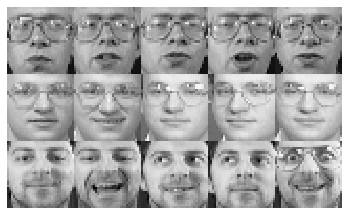

In [554]:
# the easiest images will be correctly classified by our experiment (all 5 will be correctly classified)
easiest_indices = list()
kinda_hard = list()
hardest_indices = list()

for i in range(40):
    number_of_matches = 0 # variable for the number of matches
    for k in range(5):
        if confusion_matrix_labels[5*i+k] == i+1:
            number_of_matches = number_of_matches + 1
            
    if number_of_matches == 5:
        easiest_indices.append(5*i)
        easiest_indices.append(5*i+1)
        easiest_indices.append(5*i+2)
        easiest_indices.append(5*i+3)
        easiest_indices.append(5*i+4)
    elif number_of_matches < 4:
        hardest_indices.append(5*i)
        hardest_indices.append(5*i+1)
        hardest_indices.append(5*i+2)
        hardest_indices.append(5*i+3)
        hardest_indices.append(5*i+4)
    elif number_of_matches == 4:
        kinda_hard.append(5*i)
        kinda_hard.append(5*i+1)
        kinda_hard.append(5*i+2)
        kinda_hard.append(5*i+3)
        kinda_hard.append(5*i+4)
        
print("Easiest subjects to recognise: ")
show_faces(testing_data[easiest_indices[0:15], :], num_per_row=5)


 Pick some subjects that are considered the most difficult to recognise by your classifier, and print the misclassified test images from these subjects below.

Hardest subjects to recognise: 


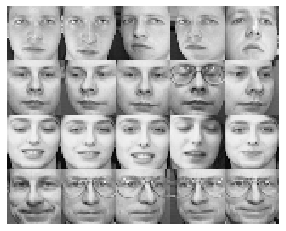

In [555]:
# the harder images will have some misclassifications (not all 5 will be correctly classified)
print("Hardest subjects to recognise: ")
# to avoid error when there are no hardest:
if(len(hardest_indices) == 0):
    print("There are no hard subjects to recognise.")
else:
    show_faces(testing_data[hardest_indices, :], num_per_row=5)

Some medium-hard images are:


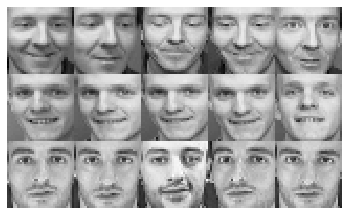

In [556]:
print("Some medium-hard images are:")
show_faces(testing_data[kinda_hard[0:15], :], num_per_row=5)

#### Experiment 3: Face Completion

The task is to predic the 512 pixels of the right face from the 512 pixels of the left face by formulating a regression task.

The following command can be used to extract the left and right faces from the input data.

In [557]:
left, right = split_left_right(data)

And you can visualise them with the function `show_split_faces()`:

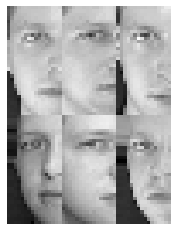

In [558]:
show_split_faces(left[:6, :], num_per_row=3)

Build a face completion model using your functions implemented earlier. Design an experiment to assess your model, which should include appropriate training and testing. Use mean absolute percentage error to evaluate the regression performance. You do not need to bother with hyper-parameter selection, but simply set $\lambda$=0.

Write your code below and make sure it compiles.

In [559]:
# Your code goes here
training_indices, testing_indices = partition_data(labels, num_per_class=3)

training_data = left[training_indices, :]
testing_data = left[testing_indices, :]
training_labels = right[training_indices]
testing_labels = right[testing_indices]

w = l2_rls_train(training_data, training_labels, 0)
predicted_y = l2_rls_predict(w, testing_data)
MAPE = np.mean(np.abs((predicted_y - testing_labels)/ testing_labels))
print("Mean absolute percentage error: " + str(MAPE) + " = " + str(MAPE*100) + "%")

Mean absolute percentage error: 0.21262525114167818 = 21.26252511416782%


Visualise and compare the ground truth face (include both the left and right parts) and the completed face (include both the true left and predicted right parts) for 3 randomly chosen testing samples below. You can use `join_left_right(left, right)` to concatenate the left and right halves of a set of faces.

Prediction:


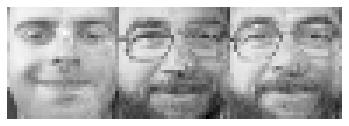

In [560]:
# Your code goes here
testing_samples = np.random.randint(testing_data.shape[0], size=(3))
# print(testing_samples)
print("Prediction:")
show_faces(join_left_right(testing_data[testing_samples, :], predicted_y[testing_samples, :]), num_per_row=3)

Reality:


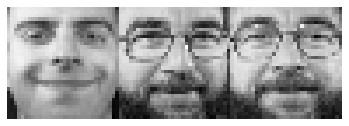

In [561]:
print("Reality:")
show_faces(join_left_right(testing_data[testing_samples, :], testing_labels[testing_samples, :]), num_per_row=3)

## 4. Gradient descent for training linear least squares model

Now, implement the function `lls_gd_train` below. It should train a single-output linear model by minimising the sum of squares loss using the gradient descent approach. It should take the iteration number $N$ and the learning rate $\eta$ as the input. To keep things simple, you can fix the initial guess of the model weights $\mathbf{w}$ as zeros. It should record and return the weights and costs of linear least squares model calculated in all the iterations.

In [562]:
def lls_gd_train(data, labels, learning_rate, N):
    """
    A summary of your function goes here.

    data: type and description of "data"
    labels: type and description of "labels"

    Returns: type and description of the returned variable(s).
    """
    
    # This is just to be consistent with the lecture notes.
    X, y = data, labels.reshape(len(labels), 1)

    # Expand X with a column of ones.
    X_tilde = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
    
    # Weight initialization
    w = np.zeros((((X_tilde.T)@X_tilde).shape[0], 1))
    cost_all = np.array([])
    w_all = np.zeros((((X_tilde.T)@X_tilde).shape[0], 1))

    # GD update of weights
    for i in range(N):
        
        # cost and gradient descent of the linear least squares model
        gd = (X_tilde.T) @ X_tilde @ w - (X_tilde.T) @ y
        cost = 1/2*((np.square(X_tilde @ w - y)).sum())
        
        
        # Weight update
        w = w - learning_rate*gd
        

        # save w and cost of each iteration in w_all and cost_all
        w_all = np.append(w_all, w, axis=1)
        cost_all = np.append(cost_all, cost)
    
    
    # Return model parameters.
    return cost_all, w_all

Apply this function to classify images from subject 1 and subject 30. You only need to conduct the experiment for one training-test trial, where 3 images from each subject are used for training and the remaining 7 images for testing.

Set your learning rate small, e.g., $\eta=10^{-3}$, and use a reasonable iteration number, e.g., $N=200$, to train your model. Plot in three figures (1) the change of your sum-of-squares error loss that you minimise, (2) the change of the classification accuracy for training samples, and (3) the change of the classification accuracy for test samples over iterations. Write your code below and make sure it compiles. 

In [563]:
# Your code goes here
def experiment4(learn_rate):
    training_indices, testing_indices = partition_data(labels, num_per_class=3)
    training_indices = training_indices[(labels[training_indices] == 1) | (labels[training_indices] == 30)]
    testing_indices = testing_indices[(labels[testing_indices] == 1) | (labels[testing_indices] == 30)]
    training_data = data[training_indices, :]
    testing_data = data[testing_indices, :]
    
    # we will use binary classification - the two classes are 1 and -1 
    training_labels = np.array([-1, -1, -1, 1, 1, 1])
    testing_labels = np.array([-1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1])
    N = 200
    cost_all, w_all = lls_gd_train(training_data, training_labels, learn_rate, N)
    
    # plot 1 - the cost
    plt.figure(figsize=(10,10))
    plt.plot(np.arange(1,N+1), cost_all)
    plt.title("The change of our sum-of-squares error loss")
    plt.xlabel("Number of iterations")
    plt.ylabel("Sum-of-squares error")
    plt.show()
    
    # plot 2 - accuracy for training samples
    training_prediction = (l2_rls_predict(w_all, training_data) > 0)*2-1 # class 1 will output 1, and class -1 will output -1
    training_accuracy = (training_prediction == training_labels.reshape(6,1)).sum(axis=0)/training_data.shape[0]
    plt.figure(figsize=(10,10))
    plt.plot(np.arange(1, N+2), training_accuracy)
    plt.title("The change of the classification accuracy for training samples")
    plt.xlabel("Number of iterations")
    plt.ylabel("Accuracy")
    plt.show()
    
    # plot 3 - accuracy for testing samples
    testing_prediction = (l2_rls_predict(w_all, testing_data) > 0)*2-1 # class 1 will output 1, and class -1 will output -1
    testing_accuracy = (testing_prediction == testing_labels.reshape(14,1)).sum(axis=0)/testing_data.shape[0]
    plt.figure(figsize=(10,10))
    plt.plot(np.arange(1, N+2), testing_accuracy)
    plt.title("The change of the classification accuracy for testing samples")
    plt.xlabel("Number of iterations")
    plt.ylabel("Accuracy")
    plt.show()
    

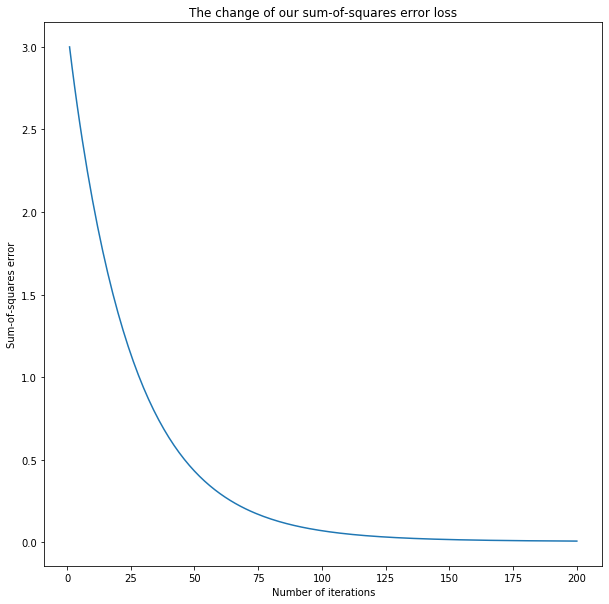

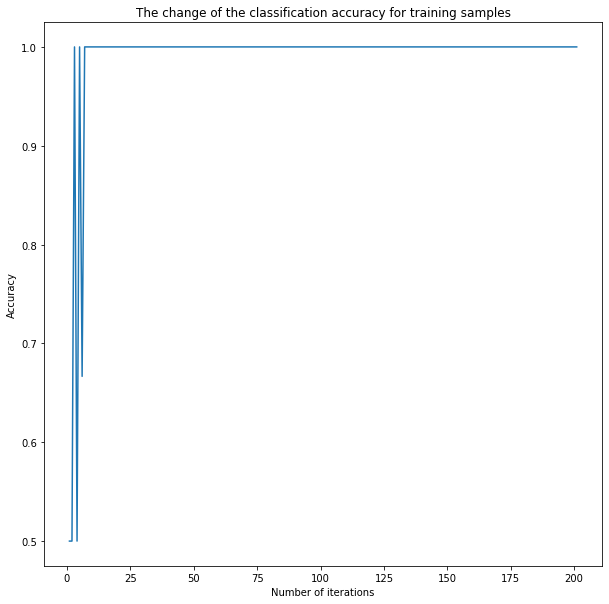

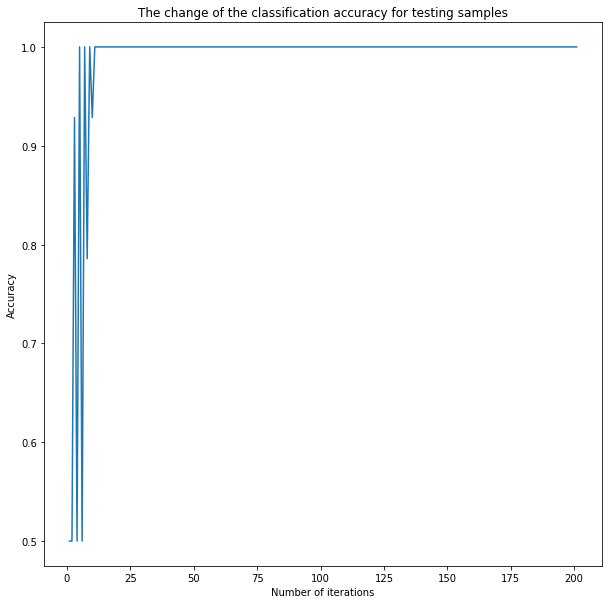

In [564]:
experiment4(0.001)

Try a larger learning rate, e.g., $\eta=10^{-2}$, and produce the same three plots by training the model for $N=200$ iterations. Write your code below and make sure it compiles. 

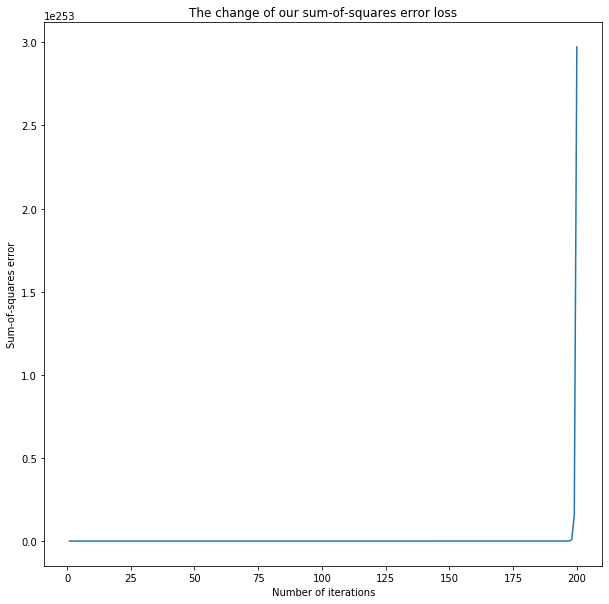

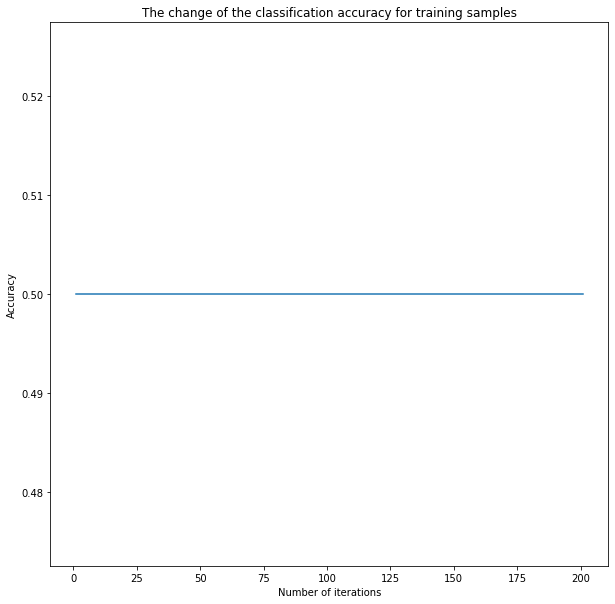

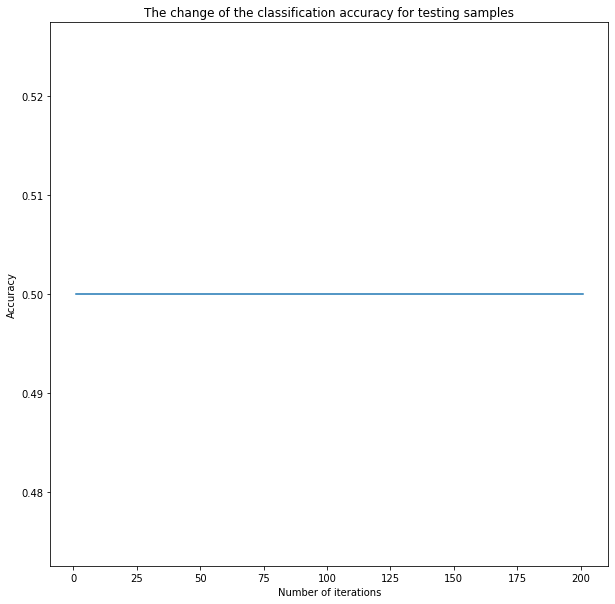

In [565]:
# Your code goes here
experiment4(0.003)

#### Remember that all graphs should have axis labels and a title.

## 5. Reflection and analysis
Finally, observe and reflect on all the results you have obtained in each experiment, and try to interpret them using your machine learning knowledge. Be ready to answer the questions asked by GTA in your face-to-face marking, regarding to your implementation, results, as well as analysis and interpretation of your results.